In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5' 
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from sklearn.preprocessing import MinMaxScaler
import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Reshape, Layer
from tensorflow.keras.layers import Dropout, ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError
import tensorflow_probability as tfp

# for SNGP
import gpflow
import gpflux
from gpflow.config import default_float
from lib.spectral_normalization import SpectralNormalization

from tensorflow.keras import Model
from sklearn.metrics import mean_absolute_error as mae

from os import listdir
from os.path import isfile, join
from tqdm import tqdm


plt.rcParams.update({'font.size': 18})

In [2]:
mypath = 'N-CMAPSS_DL/N-CMAPSS/Samples_whole/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(onlyfiles)

train_units = [2,5,10,16,18,20]
test_units = [11,14,15]

test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
train_files = list(set(onlyfiles) - set(test_files))
print(train_files)

['Unit5_win1_str1_smp500.npz', 'Unit2_win1_str1_smp500.npz', 'Unit16_win1_str1_smp500.npz', 'Unit10_win1_str1_smp500.npz', 'Unit18_win1_str1_smp500.npz', 'Unit20_win1_str1_smp500.npz', 'Unit11_win1_str1_smp500.npz', 'Unit14_win1_str1_smp500.npz', 'Unit15_win1_str1_smp500.npz']
['Unit16_win1_str1_smp500.npz', 'Unit2_win1_str1_smp500.npz', 'Unit20_win1_str1_smp500.npz', 'Unit5_win1_str1_smp500.npz', 'Unit10_win1_str1_smp500.npz', 'Unit18_win1_str1_smp500.npz']


In [3]:
def load_part_array_merge (current_dir, npz_units):
    sample_array_lst = []
    label_array_lst = []
    for npz_unit in npz_units:
      loaded = np.load(current_dir + npz_unit)
      sample_array_lst.append(loaded['sample'])
      label_array_lst.append(loaded['label'])
    sample_array = np.dstack(sample_array_lst)
    label_array = np.concatenate(label_array_lst)
    sample_array = sample_array.transpose(2, 0, 1)
    return sample_array, label_array

In [4]:
Xtrain_norm,Ytrain = load_part_array_merge(mypath,train_files)
Xtest_norm,Ytest = load_part_array_merge(mypath,test_files)
print(Xtrain_norm.shape)
Xtrain_norm = Xtrain_norm[:,0,:]
Xtest_norm = Xtest_norm[:,0,:]
Ytrain_norm = np.expand_dims((Ytrain)/np.max(Ytrain),1)
#Ytrain_norm = (Ytrain)/np.max(Ytrain)
Ytest_norm = np.expand_dims((Ytest)/np.max(Ytrain),1)
#Ytest_norm = (Ytest)/np.max(Ytrain)

(10527, 1, 20)


In [5]:
test_units = [11]
test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
Xtest11_norm,Ytest11 = load_part_array_merge(mypath,test_files)
Xtest11_norm = Xtest11_norm[:,0,:]
Ytest11_norm = np.expand_dims((Ytest11)/np.max(Ytrain),1)


test_units = [14]
test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
Xtest14_norm,Ytest14 = load_part_array_merge(mypath,test_files)
Xtest14_norm = Xtest14_norm[:,0,:]
Ytest14_norm = np.expand_dims((Ytest14)/np.max(Ytrain),1)


test_units = [15]
test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
Xtest15_norm,Ytest15 = load_part_array_merge(mypath,test_files)
Xtest15_norm = Xtest15_norm[:,0,:]
Ytest15_norm = np.expand_dims((Ytest15)/np.max(Ytrain),1)

In [6]:
# Get calibration curves
def get_confidence_interval(y_true, mu, sigma):
    """
    Input: 
    y_true - true values
    mu     - predicted mean
    sigma  - predicted standard deviation
    
    Output:
    exp_CIs - expected confidence
    pred_CIs - predicted confidence
    """
    exp_CIs = np.linspace(1e-10, 1-1e-10, 1000)
    pred_CIs=[]
    for exp_CI in tqdm(sorted(exp_CIs)):
        intervals = scipy.stats.norm.interval(exp_CI, loc=mu, scale=sigma)
        lower_bd = intervals[0]
        upper_bd = intervals[1]
        pred_CIs.append(np.sum((y_true > lower_bd) & (y_true < upper_bd))/len(y_true))
    
    ECE = np.mean(np.abs(exp_CIs - pred_CIs))
    return 100*exp_CIs, 100*np.array(pred_CIs), ECE*100  # converting to percentages


def get_rmse(y_true, y_pred):
    """
    Inputs:
    y_true - true values
    y_pred - predicted values
    Outputs:
    root mean squarred error
    """
    return np.sqrt(np.mean((y_true-y_pred)**2))

def get_nll(y_true, y_pred, s_pred):
    """
    Inputs:
    y_true - true values
    y_pred - predicted values
    s_pred - predicted standard deviation
    Outputs:
    median of NLL
    """
    return np.median(np.log(s_pred**2)/2 + 
                     np.divide((y_true - y_pred)**2, 2* s_pred**2))



# Get calibration curves
def get_alpha_lambda(y_true, mu, alpha):
    lower_bd = y_true + y_true*alpha
    upper_bd = y_true - y_true*alpha
    alambda = np.sum((mu > lower_bd) & (mu < upper_bd))/len(y_true)
    return alambda  # converting to percentages



def get_error_metrics(pred_df, UQmodelcode):
    dataset = ['train', 'test11', 'test14', 'test15']
    if UQmodelcode == 'GP':
        niters = {0}
    else:
        niters = set(pred_df['iteration'])
    
    results_df = pd.DataFrame()
    results_df['dataset'] = dataset
    
    allrmse, allnll, allece = [], [], []
    for myset in dataset:
        myrmse, mynll, myece = np.zeros(len(niters),), np.zeros(len(niters),), np.zeros(len(niters),)
        for myiter in niters:
            if UQmodelcode == 'GP':
                df = pred_df.loc[(pred_df['dataset']==myset)]
            else:
                df = pred_df.loc[(pred_df['dataset']==myset) & (pred_df['iteration']==myiter)]
            myrmse[myiter] = get_rmse(df['True'], df[UQmodelcode+'_mu_eff'])
            mynll[myiter]  = get_nll(df['True'], df[UQmodelcode+'_mu_eff'], 
                                     df[UQmodelcode+'_sigma_eff'])
            exp_CI, CI_MC, myece[myiter] = get_confidence_interval(df['True'].values, 
                                             df[UQmodelcode+'_mu_eff'].values, 
                                             df[UQmodelcode+'_sigma_eff'].values)
            
        allrmse.append(myrmse)
        allnll.append(mynll)
        allece.append(myece)
    
    results_df['rmse_mean'] = np.mean(allrmse,axis = 1)
    results_df['rmse_std']  = np.std(allrmse,axis = 1)
    
    results_df['nll_mean'] = np.mean(allnll,axis = 1)
    results_df['nll_std']  = np.std(allnll,axis = 1)
    
    results_df['ece_mean'] = np.mean(allece,axis = 1)
    results_df['ece_std']  = np.std(allece,axis = 1)
    results_df = results_df.round(1)
    
    results_df['rmse']=results_df['rmse_mean'].astype(str) + "±" + results_df['rmse_std'].astype(str)
    results_df['nll'] =results_df['nll_mean'].astype(str) + "±" + results_df['nll_std'].astype(str)
    results_df['ece'] =results_df['ece_mean'].astype(str) + "±" + results_df['ece_std'].astype(str)

    return results_df
    

In [7]:
allresults_SNGPdf=pd.read_excel("results/SNGP_CMAPPS_results.xlsx")

allresults_MCdf=pd.read_excel("results/MCDropout_CMAPPS_results.xlsx")

allresults_DEdf=pd.read_excel("results/DeepEnsemble_CMAPPS_results.xlsx")

In [8]:
np.unique(allresults_DEdf['iteration'].values)
niter = 10

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1770.51it/s]


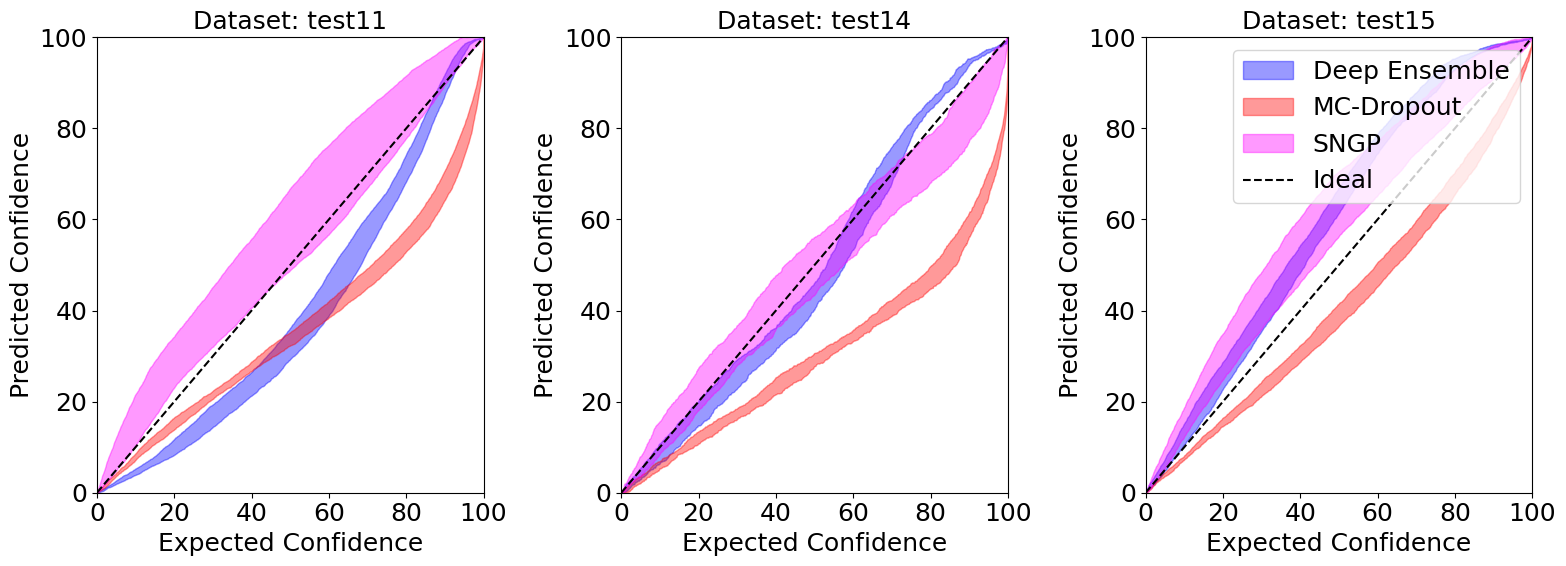

In [9]:
fig, ax = plt.subplots(1,3,figsize=(16, 6))
dataset = [ 'test11', 'test14', 'test15']

# plotting DE and MC
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    
    allCI_DE = np.zeros((1000, niter))
    allCI_MC = np.zeros((1000, niter))
    allCI_SNGP = np.zeros((1000, niter))
    for myiter in range(niter):
        df = allresults_MCdf.loc[(allresults_MCdf['dataset']==dataset[myset]) & 
                                 (allresults_MCdf['iteration']==myiter)]
        exp_CI, CI_MC, ECE = get_confidence_interval(df['True'].values, 
                                               df['MC_mu_eff'].values, 
                                               df['MC_sigma_eff'].values)
        allCI_MC[:,myiter] = CI_MC
        
        df = allresults_DEdf.loc[(allresults_DEdf['dataset']==dataset[myset]) & 
                                 (allresults_DEdf['iteration']==myiter)]
        exp_CI, CI_DE, ECE = get_confidence_interval(df['True'].values, 
                                               df['DE_mu_eff'].values, 
                                               df['DE_sigma_eff'].values)
        allCI_DE[:,myiter] = CI_DE
        
        df = allresults_SNGPdf.loc[(allresults_SNGPdf['dataset']==dataset[myset]) & 
                                 (allresults_SNGPdf['iteration']==myiter)]
        exp_CI, CI_SNGP, ECE = get_confidence_interval(df['True'].values, 
                                               df['SNGP_mu_eff'].values, 
                                               df['SNGP_sigma_eff'].values)
        allCI_SNGP[:,myiter] = CI_SNGP
        
        
    myax.fill_between(exp_CI,
                np.mean(allCI_DE, axis = 1)+np.std(allCI_DE, axis = 1),
                np.mean(allCI_DE, axis = 1)-np.std(allCI_DE, axis = 1),
                color='blue', alpha = 0.4, linestyle='None', label='Deep Ensemble')
    
    myax.fill_between(exp_CI,
                np.mean(allCI_MC, axis = 1)+np.std(allCI_MC, axis = 1),
                np.mean(allCI_MC, axis = 1)-np.std(allCI_MC, axis = 1),
                color='red', alpha = 0.4, linestyle='None', label='MC-Dropout')
    
    myax.fill_between(exp_CI,
                np.mean(allCI_SNGP, axis = 1)+np.std(allCI_SNGP, axis = 1),
                np.mean(allCI_SNGP, axis = 1)-np.std(allCI_SNGP, axis = 1),
                color='magenta', alpha = 0.4, linestyle='None', label='SNGP')
    
    myax.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')


    myax.set_title("Dataset: "+ dataset[myset], fontsize = 18)
    myax.set_xlabel("Expected Confidence")
    myax.set_ylabel("Predicted Confidence")
    myax.set_xlim([0,100])
    myax.set_ylim([0,100])
    if myset == 2:
        myax.legend()
#         myax.legend(loc='upper center', bbox_to_anchor=(1.0, -1.45), ncol=3, fancybox=True)

plt.tight_layout()
fig.savefig("figures/calibration_curves.jpg")

In [11]:
df = get_error_metrics(allresults_MCdf,'MC')
df[['dataset', 'rmse', 'nll', 'ece']]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1748.14it/s]


,dataset,rmse,nll,ece
0,train,9.3±0.1,2.2±0.0,10.3±0.7
1,test11,9.0±0.5,2.4±0.1,13.9±1.6
2,test14,10.3±0.1,2.7±0.1,19.1±1.0
3,test15,7.2±0.2,2.2±0.0,8.3±1.5


In [12]:
df = get_error_metrics(allresults_DEdf,'DE')
df[['dataset', 'rmse', 'nll', 'ece']]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1885.06it/s]


,dataset,rmse,nll,ece
0,train,8.5±0.0,2.2±0.0,4.6±0.7
1,test11,8.8±0.2,2.5±0.0,10.3±2.1
2,test14,10.7±0.1,2.3±0.0,4.1±0.9
3,test15,8.3±0.2,2.2±0.0,9.9±1.9


In [13]:
df = get_error_metrics(allresults_SNGPdf,'SNGP')
df[['dataset', 'rmse', 'nll', 'ece']]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2043.66it/s]


,dataset,rmse,nll,ece
0,train,11.1±0.9,2.6±0.0,7.2±2.2
1,test11,9.9±1.6,2.6±0.1,7.2±5.0
2,test14,13.1±1.5,2.7±0.1,4.7±2.5
3,test15,9.5±1.2,2.6±0.0,9.1±3.9


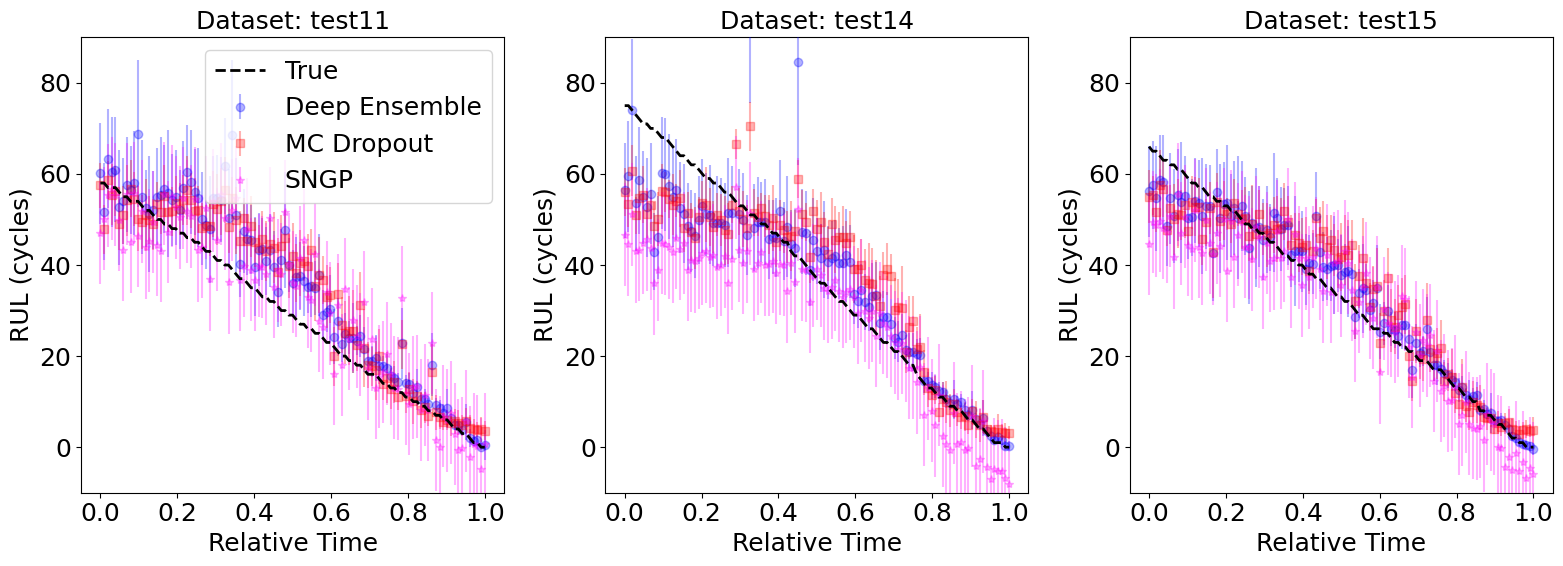

In [16]:
dataset = ['test11', 'test14', 'test15']

allresults_DEdf_sorted = allresults_DEdf.loc[allresults_DEdf['iteration']==0]
allresults_MCdf_sorted = allresults_MCdf.loc[allresults_MCdf['iteration']==0]
allresults_SNGPdf_sorted = allresults_SNGPdf.loc[allresults_SNGPdf['iteration']==0]

fig, ax = plt.subplots(1,3,figsize=(16, 6))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    
    
    df = allresults_DEdf_sorted.loc[allresults_DEdf_sorted['dataset']==dataset[myset]]
    down = int(len(df)/100)
    df = df.iloc[::down]
    x=np.array([i*500 for i in range(df.shape[0])])

    myax.plot(x/max(x), df['True'], 
             color='black', linestyle='dashed', linewidth=2, label='True',zorder=4)
    
    myax.errorbar(x/max(x), df['DE_mu_eff'], 
                 yerr = df['DE_sigma_eff'],
                 fmt='o', color='blue', alpha = 0.3, label='Deep Ensemble',zorder=3)
    
    df = allresults_MCdf_sorted.loc[allresults_MCdf_sorted['dataset']==dataset[myset]]
    down = int(len(df)/100)
    df = df.iloc[::down]
    x=np.array([i*500 for i in range(df.shape[0])])
    myax.errorbar(x/max(x), df['MC_mu_eff'], 
                 yerr = df['MC_sigma_eff'],
                 fmt='s', color='red', alpha = 0.3, label='MC Dropout',zorder=3)
    
    df = allresults_SNGPdf_sorted.loc[allresults_SNGPdf_sorted['dataset']==dataset[myset]]
    down = int(len(df)/100)
    df = df.iloc[::down]
    x=np.array([i*500 for i in range(df.shape[0])])
    myax.errorbar(x/max(x), df['SNGP_mu_eff'], 
                  yerr = df['SNGP_sigma_eff'],
                      fmt='*', color='magenta', alpha = 0.3, label='SNGP',zorder=3)

    
#    df = allresults_GPdf_sorted.loc[allresults_GPdf_sorted['dataset']==dataset[myset]]
#    myax.errorbar(range(df.shape[0]), df['GP_mu_eff'], 
#                 yerr = df['GP_sigma_eff'],markersize = 10,
#                 fmt='*', color='darkgreen', alpha = 0.6, label='Gaussian process')
    
    
    myax.set_title("Dataset: "+ dataset[myset], fontsize=18)
    myax.set_xlabel("Relative Time")
    myax.set_ylabel("RUL (cycles)")
    myax.set_xticks(np.arange(0, 1.2, 0.2))
    myax.set_ylim([-10, 90])
    if myset ==0:
        myax.legend()
plt.tight_layout()
fig.savefig("figures/ascending_errors.jpg")